In [35]:
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier 
import matplotlib.pyplot as plt 

from sklearn import metrics
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

import unicodedata
#from wordcloud import WordCloud
from nltk.corpus import stopwords
import string 
from nltk.stem import WordNetLemmatizer
import re
import copy

from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

In [11]:
data=pd.read_csv("train.csv")
data.head()

,id,text,category
0,3973,1047 6700 4178 2912 183 6700,0
1,4462,4035 4563 1994 154 5373 4956 6035 4393 4017 40...,1
2,2889,5035 7685 3139 4407 254 584 6589 8518 3078,0
3,3457,1047 2540 2578 6700 2242 230 3771 4676 5881 64...,0
4,1555,7685 5868 237 6794 3078,0


#### Check for Class Imbalance

In [45]:
data['category'].value_counts()/len(data)

0    0.966898
1    0.033102
Name: category, dtype: float64

Counter({0: 2512, 1: 86})


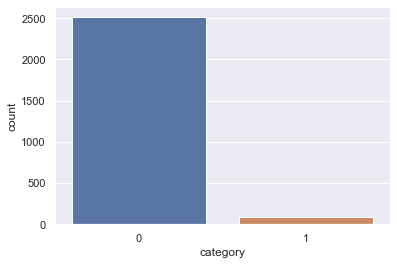

In [43]:
import collections
import seaborn as sns
counter = collections.Counter(data['category'])
print(counter)

sns.set(style="darkgrid")
ax = sns.countplot(x="category", data=data)

In [13]:
data.shape

(2598, 3)

In [14]:
data.isnull().sum()

id          0
text        0
category    0
dtype: int64

from sklearn.naive_bayes import MultinomialNB

In [15]:
X=data['text']
y=data['category']


In [16]:
def run_model(dataframe,
              target,
              vectorizer=TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=0.02),
              model=MultinomialNB()
             ):
    '''
    Performs model training and validate using f1-score
    '''
    X = dataframe
    y = target
    vect = vectorizer
    
    # splitting data into training and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0, test_size=0.3)
    
    # Vectorize
    vector = vect.fit(X_train)
    X_train_vect = vector.transform(X_train).toarray()
    X_valid_vect = vector.transform(X_valid).toarray()
    
    # Fit and predict
    model.fit(X_train_vect, y_train)  
    y_pred = model.predict(X_valid_vect)  
    
    #validation using f1-score
    c_report = metrics.classification_report(y_valid, y_pred)
    print('classification report: \n', c_report)
    F1_score = f1_score(y_valid, y_pred,average='weighted')
    print('F1_score: ',F1_score) 
    
    return F1_score, y_pred

In [19]:

#from google.colab import files

from sklearn import metrics
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
models = [MultinomialNB, GaussianNB,LogisticRegression,DecisionTreeClassifier, RandomForestClassifier]
vectorizers = [TfidfVectorizer, CountVectorizer]
for vectorizer in vectorizers:
  vectorizer = vectorizer(max_df=0.9, min_df=0.02)
  for model in models:
      # run model
      model = model()
      F1_score, y_pred = run_model(X, y, vectorizer = vectorizer, model = OneVsRestClassifier(model)) 
      print('On Model - \n'+str(model),'\nwith Vectorizer - \n'+str(vectorizer))
      print('===='*20)

C:\Users\Monika\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classification report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       755
           1       0.00      0.00      0.00        25

    accuracy                           0.97       780
   macro avg       0.48      0.50      0.49       780
weighted avg       0.94      0.97      0.95       780

F1_score:  0.952184080848576
On Model - 
MultinomialNB() 
with Vectorizer - 
TfidfVectorizer(max_df=0.9, min_df=0.02)
classification report: 
               precision    recall  f1-score   support

           0       0.99      0.82      0.90       755
           1       0.11      0.68      0.19        25

    accuracy                           0.82       780
   macro avg       0.55      0.75      0.54       780
weighted avg       0.96      0.82      0.87       780

F1_score:  0.8740211037170484
On Model - 
GaussianNB() 
with Vectorizer - 
TfidfVectorizer(max_df=0.9, min_df=0.02)
classification report: 
               precision    recall  f1

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier


def ensemble(dataframe,target):
    X = dataframe
    y = target
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=0.01, max_features=1000)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
     
    # TF-IDF feature matrix
    tfidf_vectorizer.fit(X_train)
    X_train_vect = tfidf_vectorizer.transform(X_train).toarray()
    X_valid_vect = tfidf_vectorizer.transform(X_valid).toarray()
    
    
    smote = SMOTE(random_state=0)
    
    X_train_vect_sm, y_train_sm =  smote.fit_sample(X_train_vect, y_train)
    #print("X_train_vect_sm shape after smote: ",X_train_vect_sm.shape)

    
   
    model1 = RandomForestClassifier(random_state=0, n_jobs=-1, 
                                    class_weight="balanced", 
                                    criterion = 'gini',max_depth= 8,
                                    max_features = 'auto', n_estimators = 200
                                    )
    model2 = MultinomialNB()
    model3 = LogisticRegression(class_weight="balanced")
    
    model = VotingClassifier(estimators=[('rf', model1),('nb', model2), ('lr', model3)], voting='soft')
    
    model.fit(X_train_vect_sm, y_train_sm)
    y_pred = model.predict(X_valid_vect) 
    
    #validation using f1-score
    c_report = metrics.classification_report(y_valid, y_pred)
    print('classification report: \n', c_report)
    F1_score = f1_score(y_valid, y_pred,average='weighted')
    print('F1_score: ',F1_score) 
    
    return tfidf_vectorizer, model

ensemble(X,y)

classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       756
           1       0.83      0.83      0.83        24

    accuracy                           0.99       780
   macro avg       0.91      0.91      0.91       780
weighted avg       0.99      0.99      0.99       780

F1_score:  0.9897435897435898


(TfidfVectorizer(max_df=0.9, max_features=1000, min_df=0.01),
 VotingClassifier(estimators=[('rf',
                               RandomForestClassifier(class_weight='balanced',
                                                      max_depth=8,
                                                      n_estimators=200,
                                                      n_jobs=-1,
                                                      random_state=0)),
                              ('nb', MultinomialNB()),
                              ('lr',
                               LogisticRegression(class_weight='balanced'))],
                  voting='soft'))

In [32]:
test=pd.read_csv("test.csv")
print(test.head())


     id                                               text
0  1546  5222 7526 427 4829 7526 1164 4768 997 7924 332...
1  2956  590 983 5773 8352 1803 237 5045 6300 6267 5773...
2  4248       5915 4871 2982 6310 2734 3581 5773 6498 5773
3  4403  5435 1994 7248 1944 4017 3567 8618 5018 6619 3...
4  2097  6666 230 4768 2684 5773 3656 907 5922 2295 577...


In [33]:
print(test.head())
final_vectrizer, final_model = ensemble(X, y)
X_test_vect = final_vectrizer.transform(test['text']).toarray()

final_pred = final_model.predict(X_test_vect)

     id                                               text
0  1546  5222 7526 427 4829 7526 1164 4768 997 7924 332...
1  2956  590 983 5773 8352 1803 237 5045 6300 6267 5773...
2  4248       5915 4871 2982 6310 2734 3581 5773 6498 5773
3  4403  5435 1994 7248 1944 4017 3567 8618 5018 6619 3...
4  2097  6666 230 4768 2684 5773 3656 907 5922 2295 577...
classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       756
           1       0.83      0.83      0.83        24

    accuracy                           0.99       780
   macro avg       0.91      0.91      0.91       780
weighted avg       0.99      0.99      0.99       780

F1_score:  0.9897435897435898


In [34]:
#Create a  DataFrame with the tweet_id and our prediction regarding sentiment
submission = pd.DataFrame({'category':final_pred})
print(submission.shape)
submission.to_csv('submission_4.csv', index=False)


(866, 1)
